# Sentiment Analysis with Tweet Sentiment Dataset Using Traditional Machine Learning Models

* This notebook provides a comprehensive guide to performing sentiment analysis on the Tweet Sentiment dataset using traditional machine learning models. We will preprocess the dataset, vectorize the text data, train several models, and evaluate their performance. The models we will cover include `Logistic Regression, Support Vector Machines (SVM), Random Forests, Naive Bayes, Gradient Boosting Machines (GBM), and XGBoost`.

## Import Libraries

In [1]:
import pandas as pd
import re
import nltk
import random
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import time
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

## Load and Preprocess the Dataset

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# translator = Translator()

def load_parquet_as_dataframe(parquet_file_path):
    """
    Load Parquet file into a pandas DataFrame.
    
    Args:
        parquet_file_path (str): Path to the Parquet file.
        
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    df = pd.read_parquet(parquet_file_path)
    return df

def preprocess_text(text):
    """
    Preprocess text by removing mentions, URLs, special characters, and stop words.
    
    Args:
        text (str): Raw text data.
        
    Returns:
        str: Cleaned text data.
    """
    text = re.sub(r'(@\w+|http\S+)', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


# def prepare_data(df, sample_size=10000):
#     """
#     Prepare data by preprocessing text and splitting into train, validation, and test sets.
    
#     Args:
#         df (pd.DataFrame): DataFrame containing the dataset.
#         sample_size (int): Number of samples to use for the entire process.
        
#     Returns:
#         tuple: Split and preprocessed data (X_train, X_valid, X_test, y_train, y_valid, y_test).
#     """
#     df['cleaned_text'] = df['text'].apply(preprocess_text)
    
#     # Map labels from [0, 2, 4] to [0, 1, 2]
#     label_mapping = {0: 0, 2: 1, 4: 2}
#     df['polarity'] = df['polarity'].map(label_mapping)
    
#     X = df['cleaned_text']
#     y = df['polarity']
    
#     # Use train_test_split for stratified sampling
#     X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
    
#     # Split the sampled data
#     X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, train_size=0.8, random_state=42, stratify=y_sample)
    
#     return X_train, X_test, y_train, y_test

[nltk_data] Downloading package stopwords to /home/omar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/omar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/omar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading The Data

In [4]:
# Load datasets
train_file_path = 'datasets/tweet_eval_train.parquet'
test_file_path = 'datasets/tweet_eval_test.parquet'

df_train = load_parquet_as_dataframe(train_file_path)
df_test = load_parquet_as_dataframe(test_file_path)

### show insights For Data

In [29]:
# Basic Information about the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45615 entries, 0 to 45614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    45615 non-null  object
 1   label   45615 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 712.9+ KB


In [30]:
# Basic Statistics
df_train.describe()

,label
count,45615.000000
mean,1.235800
std,0.700859
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [31]:
# Missing values in each column
df_train.isnull().sum()

text     0
label    0
dtype: int64

### Show class distribution

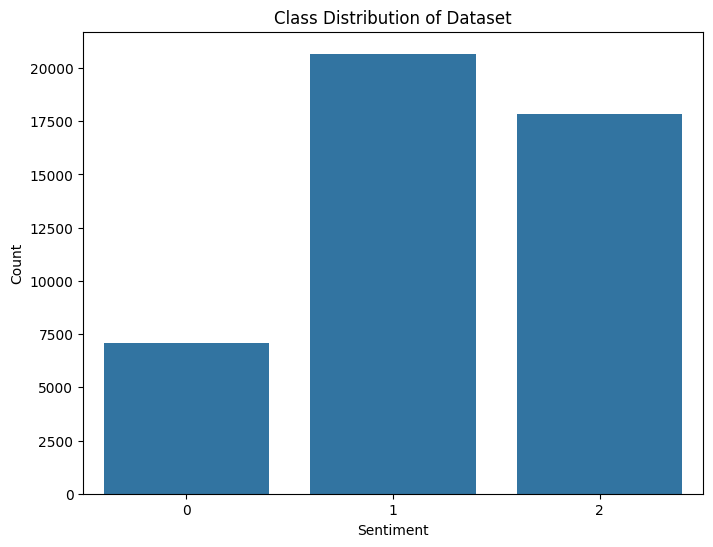

In [32]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_train)
plt.title("Class Distribution of Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [33]:
df_train['label'].value_counts()

label
1    20673
2    17849
0     7093
Name: count, dtype: int64

## Trying To Solve Imbalance of Data

### Using `SMOTE` to solve imbalance in classes of data
* SMOTE (Synthetic Minority Over-sampling Technique)

     SMOTE is a popular technique used to address the class imbalance problem in datasets. When dealing with imbalanced datasets, where one class significantly outnumbers the other(s), standard machine learning algorithms tend to be biased towards the majority class. SMOTE helps mitigate this issue by generating synthetic samples for the minority class.

* How SMOTE Works:

     1. Identify Minority Samples: SMOTE identifies samples from the minority class.
     2. Generate Synthetic Samples: It generates new synthetic samples by selecting two or more similar instances in the feature space and interpolating between them. This is done by choosing a random point along the line between these instances.
     3. Balance the Dataset: The synthetic samples are added to the dataset, which helps to balance the class distribution.

#### Vectorize the Text Data Using TF-IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_data(X_train, X_test):
    """
    Vectorize text data using TF-IDF.
    
    Args:
        X_train (pd.Series): Training data.
        X_test (pd.Series): Test data.
        
    Returns:
        tuple: Vectorized data (X_train_tfidf, X_test_tfidf).
    """
    vectorizer = TfidfVectorizer(max_features=10000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf


#### Using `SMOTE`

Label Distribution After SMOTE:
{0: 20673, 1: 20673, 2: 20673}


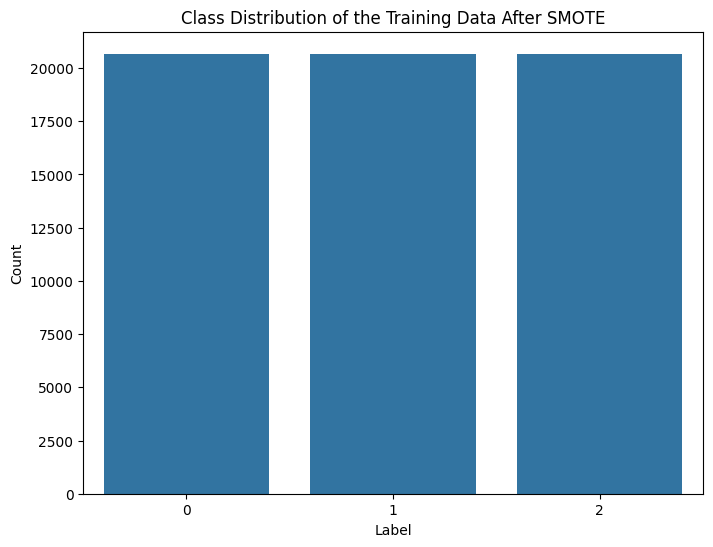

In [34]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Preprocess text data
df_train['cleaned_text'] = df_train['text'].apply(preprocess_text)
df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)

# Vectorize text data
X_train_tfidf_smote, X_test_tfidf_smote = vectorize_data(df_train['cleaned_text'], df_test['cleaned_text'])

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf_smote, df_train['label'])

# Show data and label distribution after SMOTE
print("Label Distribution After SMOTE:")
unique, counts = np.unique(y_train_smote, return_counts=True)
smote_label_counts = dict(zip(unique, counts))
print(smote_label_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title("Class Distribution of the Training Data After SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

#### Train Machine Learning Models

In [21]:
def train_models(models, X_train, y_train):
    """
    Train multiple models.
    
    Args:
        models (list): List of sklearn model instances.
        X_train (sparse matrix): Training data.
        y_train (pd.Series): Training labels.
        
    Returns:
        list: List of trained models.
    """
    trained_models = []
    for model in tqdm(models, desc="Training Models"):
        model_name = model.__class__.__name__
        print(f"Training {model_name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        trained_models.append((model, training_time))
        print(f"{model_name} training complete in {training_time:.2f} seconds.")
        print("="*60)
    return trained_models

In [36]:
# Initialize models
models = [
    LogisticRegression(max_iter=1000),
    SVC(),
    RandomForestClassifier(),
    MultinomialNB(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier(objective='multi:softprob', num_class=3)
]

# Train models
trained_models_smote = train_models(models, X_train_smote, y_train_smote)

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

Training LogisticRegression...


Training Models:  17%|█▋        | 1/6 [00:16<01:22, 16.45s/it]

LogisticRegression training complete in 16.45 seconds.
Training SVC...


Training Models:  33%|███▎      | 2/6 [18:52<44:12, 663.24s/it]

SVC training complete in 1116.00 seconds.
Training RandomForestClassifier...


Training Models:  50%|█████     | 3/6 [20:55<20:49, 416.42s/it]

RandomForestClassifier training complete in 122.70 seconds.
Training MultinomialNB...
MultinomialNB training complete in 0.01 seconds.
Training GradientBoostingClassifier...


Training Models:  83%|████████▎ | 5/6 [22:07<03:21, 201.20s/it]

GradientBoostingClassifier training complete in 72.46 seconds.
Training XGBClassifier...


Training Models: 100%|██████████| 6/6 [22:47<00:00, 227.95s/it]

XGBClassifier training complete in 40.07 seconds.


#### Evaluate and Show The Results

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_models(trained_models, X_test, y_test):
    """
    Evaluate multiple trained models.
    
    Args:
        trained_models (list): List of tuples containing trained models and their training times.
        X_test (sparse matrix): Test data.
        y_test (pd.Series): Test labels.
        
    Returns:
        pd.DataFrame: DataFrame containing evaluation results.
    """
    results = []
    for model, training_time in trained_models:
        model_name = model.__class__.__name__
        y_test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        report = classification_report(y_test, y_test_pred)
        
        results.append({
            'model': model_name,
            'test_accuracy': test_acc,
            'training_time': training_time,
            'classification_report': report
        })
    
    results_df = pd.DataFrame(results)
    return results_df


/tmp/ipykernel_5441/1047919009.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='test_accuracy', data=results_df_smote, palette='viridis')


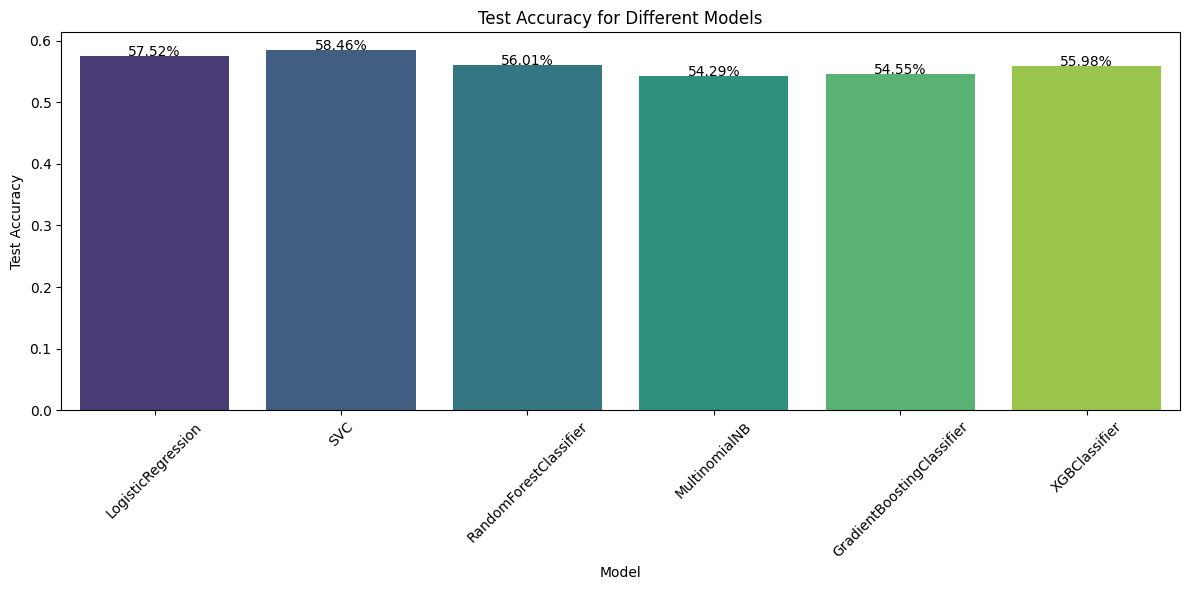

In [37]:
# Evaluate models
results_df_smote = evaluate_models(trained_models_smote, X_test_tfidf_smote, df_test['label'])

# Plotting
plt.figure(figsize=(12, 6))

# Bar plot for test accuracy
sns.barplot(x='model', y='test_accuracy', data=results_df_smote, palette='viridis')
plt.title('Test Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)

# Adding accuracy values on top of the bars
for index, row in results_df_smote.iterrows():
    plt.text(index, row.test_accuracy, f"{row.test_accuracy:.2%}", color='black', ha="center")

plt.tight_layout()
plt.show()

### Text Data Augmentation Techniques:
That For solving imbalance in classes

1. Synonym Replacement:
    * Randomly replace words in the text with their synonyms using a thesaurus or a word embedding model.

2. Random Insertion:
    * Randomly insert new words at random positions in the sentence using synonyms or related words.

3. Random Deletion:
    * Randomly remove words from the sentence with a certain probability.

4. Random Swap:
    * Randomly swap the positions of two words in the sentence.

5. Back Translation:
    * Translate the text to another language and then back to the original language to generate paraphrases.

In [5]:
def get_synonyms(word):
    """
    Get synonyms for the given word.
    
    Args:
        word (str): The word to find synonyms for.
        
    Returns:
        set: A set of synonyms for the word.
    """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in 'abcdefghijklmnopqrstuvwxyz '])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(text, n):
    """
    Perform synonym replacement on the given text.
    
    Args:
        text (str): The text to augment.
        n (int): The number of words to replace with synonyms.
        
    Returns:
        str: Augmented text with synonyms replaced.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # Only replace up to n words
            break

    sentence = ' '.join(new_words)
    return sentence

def random_insertion(text, n):
    """
    Perform random insertion on the given text.
    
    Args:
        text (str): The text to augment.
        n (int): The number of words to insert randomly.
        
    Returns:
        str: Augmented text with random words inserted.
    """
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return ' '.join(new_words)

def add_word(new_words):
    """
    Add a random synonym of a random word in the list of words.
    
    Args:
        new_words (list): List of words to insert a synonym into.
    """
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words) - 1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words) - 1)
    new_words.insert(random_idx, random_synonym)

def random_deletion(text, p):
    """
    Perform random deletion on the given text.
    
    Args:
        text (str): The text to augment.
        p (float): The probability of deleting each word.
        
    Returns:
        str: Augmented text with random words deleted.
    """
    words = text.split()
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words) - 1)
        return ' '.join([words[rand_int]])
    return ' '.join(new_words)

# augment data for only min class
def augment_data_min(df, label_column, text_column, max_diff=2000):
    """
    Augment the dataset, focusing more on the minority class until it reaches within the max_diff from the majority class.
    
    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        label_column (str): The column name of the labels in the DataFrame.
        text_column (str): The column name of the text data in the DataFrame.
        max_diff (int): Maximum allowable difference between the counts of each class.
        
    Returns:
        pd.DataFrame: Augmented DataFrame.
    """
    augmented_data = []
    label_counts = df[label_column].value_counts()
    max_label_count = label_counts.max()
    
    min_label = label_counts.idxmin()
    min_label_count = label_counts[min_label]
    augment_size = max_label_count - min_label_count - max_diff

    while augment_size > 0:
        df_label = df[df[label_column] == min_label]
        
        augmented_texts = []
        for _ in range(augment_size // len(df_label) + 1):
            augmented_texts.extend(df_label[text_column].apply(lambda x: synonym_replacement(str(x), 2)))
            augmented_texts = list(map(lambda x: random_insertion(x, 2), augmented_texts))
            augmented_texts = list(map(lambda x: random_deletion(x, 0.1), augmented_texts))
        
        augmented_texts = augmented_texts[:augment_size]  # Limit the number of augmentations
        augmented_data.append(pd.DataFrame({text_column: augmented_texts, label_column: min_label}))
        
        df = pd.concat([df, pd.DataFrame({text_column: augmented_texts, label_column: min_label})], ignore_index=True)
        label_counts = df[label_column].value_counts()
        min_label = label_counts.idxmin()
        min_label_count = label_counts[min_label]
        augment_size = max_label_count - min_label_count - max_diff
    
    return df

# Augmention with balance all classes to the maximum class size.
def augment_data_all(df, label_column, text_column):
    """
    Augment the dataset to balance all classes to the maximum class size.
    
    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        label_column (str): The column name of the labels in the DataFrame.
        text_column (str): The column name of the text data in the DataFrame.
        
    Returns:
        pd.DataFrame: Augmented DataFrame.
    """
    augmented_data = []

    # Get the label distribution
    label_counts = df[label_column].value_counts()
    max_count = label_counts.max()

    for label in label_counts.index:
        df_label = df[df[label_column] == label]
        while len(df_label) < max_count:
            augmented_texts = df_label[text_column].apply(lambda x: synonym_replacement(x, 2))
            augmented_texts = augmented_texts.apply(lambda x: random_insertion(x, 2))
            augmented_texts = augmented_texts.apply(lambda x: random_deletion(x, 0.1))
            augmented_data.append(pd.DataFrame({text_column: augmented_texts, label_column: label}))
            df_label = pd.concat([df_label, augmented_data[-1]]).head(max_count)

        augmented_data.append(df_label)
    
    augmented_df = pd.concat(augmented_data).reset_index(drop=True)
    return augmented_df



#### Combine `test` With `val` Data 
That done because val data in That approach will not be used so combine it with `train`

In [6]:
# Load train and validation datasets
train_file_path = 'datasets/tweet_eval_train.parquet'
val_file_path = 'datasets/tweet_eval_val.parquet'

df_train = load_parquet_as_dataframe(train_file_path)
df_val = load_parquet_as_dataframe(val_file_path)

# Combine train and validation datasets
df_combined = pd.concat([df_train, df_val])

# Preprocess text data
df_combined['cleaned_text'] = df_combined['text'].apply(preprocess_text)
df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)

In [7]:
# show info
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47615 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          47615 non-null  object
 1   label         47615 non-null  int64 
 2   cleaned_text  47615 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


#### Apply Augmentation On Data For Only Minority class

In [8]:
# Apply augmentation
augmented_df = augment_data_min(df_combined, 'label', 'cleaned_text')

In [9]:
# Before Aug
df_train['label'].value_counts()

label
1    20673
2    17849
0     7093
Name: count, dtype: int64

In [10]:
# After Aug
augmented_df['label'].value_counts()

label
1    21542
2    19542
0    19542
Name: count, dtype: int64

#### Apply Augmentation On Data For all class

In [11]:
# Apply augmentation
augmented_df_first = augment_data_all(augmented_df, 'label', 'cleaned_text')

In [12]:
augmented_df_first['label'].value_counts()

label
2    41084
0    41084
1    21542
Name: count, dtype: int64

#### Apply Augmentaion for Minority Class Again

In [13]:
# Apply augmentation
augmented_df_final = augment_data_min(augmented_df_first, 'label', 'cleaned_text')

In [14]:
augmented_df_final['label'].value_counts()

label
2    41084
0    41084
1    39084
Name: count, dtype: int64

#### Get train and test data

In [15]:
# Split data into training and testing
X_train_aug = augmented_df_final['cleaned_text']
y_train_aug = augmented_df_final['label']
X_test_aug = df_test['cleaned_text']
y_test_aug = df_test['label']

#### Vectorize data with `TF-IDF`

In [16]:
# Ensure the text data is string type
X_train_aug = X_train_aug.astype(str)
X_test_aug = X_test_aug.astype(str)

In [19]:
# Vectorize text data
X_train_tfidf_aug, X_test_tfidf_aug = vectorize_data(X_train_aug, X_test_aug)

#### Train Models On Augmented data 

In [22]:
def train_models_grid_search(models, X_train, y_train):
    """
    Train multiple models with grid search for hyperparameter tuning.
    
    Args:
        models (list): List of tuples containing model name and sklearn model instances.
        X_train (sparse matrix): Training data.
        y_train (pd.Series): Training labels.
        
    Returns:
        list: List of trained models with best parameters.
    """
    trained_models = []
    for name, model, params in models:
        print(f"Training {name}...")
        grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        trained_models.append((name, grid_search.best_estimator_))
        print(f"{name} training complete. Best params: {grid_search.best_params_}")
        print("="*60)
    return trained_models

# # Initialize models with hyperparameters for grid search
# models = [
#     ('LogisticRegression', LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
#     ('SVC', SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
#     ('RandomForest', RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
#     ('MultinomialNB', MultinomialNB(), {'alpha': [0.1, 1, 10]}),
#     ('GradientBoosting', GradientBoostingClassifier(), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 1]}),
#     ('XGBClassifier', xgb.XGBClassifier(objective='multi:softprob', use_label_encoder=False), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 1]})
# ]

# # Train models with grid search
# trained_models_aug = train_models_grid_search(models, X_train_tfidf_aug, y_train_aug)

# Initialize models
models = [
    LogisticRegression(max_iter=1000),
    SVC(),
    RandomForestClassifier(),
    MultinomialNB(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier(objective='multi:softprob', num_class=3)
]

# Train models
trained_models_aug = train_models(models, X_train_tfidf_aug, y_train_aug)

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

Training LogisticRegression...


Training Models:  17%|█▋        | 1/6 [00:12<01:02, 12.50s/it]

LogisticRegression training complete in 12.50 seconds.
Training SVC...


Training Models:  33%|███▎      | 2/6 [1:30:50<3:33:36, 3204.04s/it]

SVC training complete in 5438.11 seconds.
Training RandomForestClassifier...


Training Models:  50%|█████     | 3/6 [1:36:21<1:34:36, 1892.19s/it]

RandomForestClassifier training complete in 331.08 seconds.
Training MultinomialNB...
MultinomialNB training complete in 0.02 seconds.
Training GradientBoostingClassifier...


Training Models:  83%|████████▎ | 5/6 [1:38:32<14:17, 857.94s/it]   

GradientBoostingClassifier training complete in 130.35 seconds.
Training XGBClassifier...


Training Models: 100%|██████████| 6/6 [1:39:42<00:00, 997.00s/it]

XGBClassifier training complete in 69.96 seconds.


#### Evaluate And Show Results

/tmp/ipykernel_5441/232198537.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='test_accuracy', data=results_df_aug, palette='viridis')


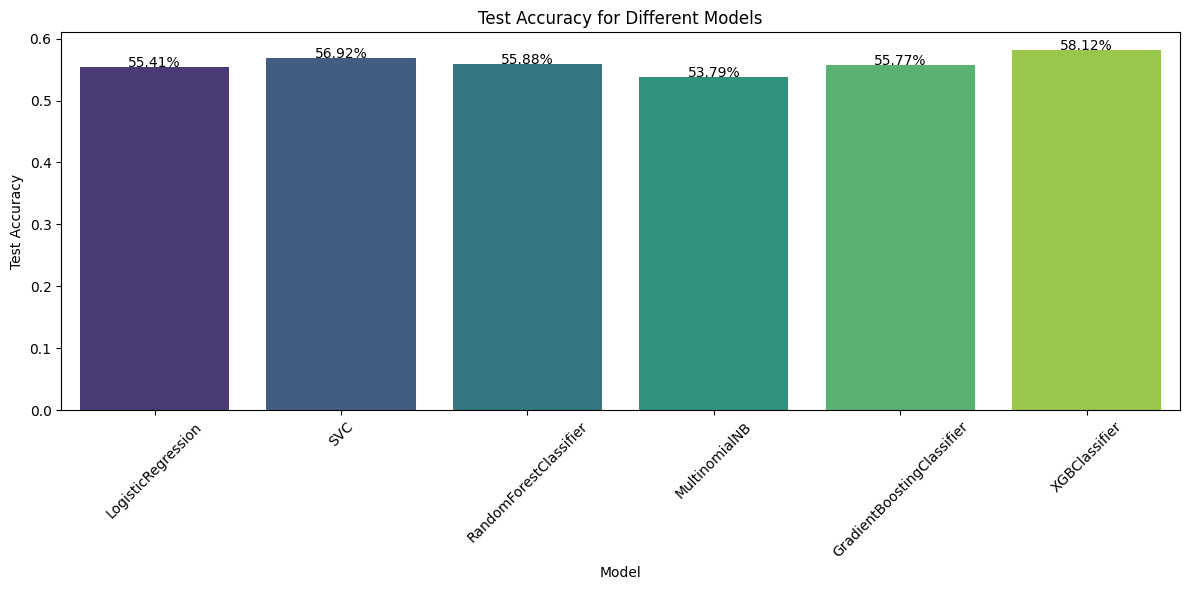

In [24]:
# Evaluate models
results_df_aug = evaluate_models(trained_models_aug, X_test_tfidf_aug, y_test_aug)

# Plotting
plt.figure(figsize=(12, 6))

# Bar plot for test accuracy
sns.barplot(x='model', y='test_accuracy', data=results_df_aug, palette='viridis')
plt.title('Test Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)

# Adding accuracy values on top of the bars
for index, row in results_df_aug.iterrows():
    plt.text(index, row.test_accuracy, f"{row.test_accuracy:.2%}", color='black', ha="center")

plt.tight_layout()
plt.show()

# # Display the DataFrame
# print(results_df_aug)


In [25]:
results_df_aug

,model,test_accuracy,training_time,classification_report
0,LogisticRegression,0.554054,12.499074,precision recall f1-score ...
1,SVC,0.569196,5438.111738,precision recall f1-score ...
2,RandomForestClassifier,0.558776,331.083675,precision recall f1-score ...
3,MultinomialNB,0.537854,0.020531,precision recall f1-score ...
4,GradientBoostingClassifier,0.557717,130.347470,precision recall f1-score ...
5,XGBClassifier,0.581162,69.957036,precision recall f1-score ...


### Text Augmention USing `nlpaug`

#### Import Libraries

In [38]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

#### Augment Data

In [42]:
def augment_data_all(df, label_column, text_column):
    """
    Augment the dataset using sequential augmentation for all classes to balance the dataset.
    
    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        label_column (str): The column name of the labels in the DataFrame.
        text_column (str): The column name of the text data in the DataFrame.
        
    Returns:
        pd.DataFrame: Augmented DataFrame.
    """
    augmented_data = []

    label_counts = df[label_column].value_counts()
    max_count = label_counts.max()
    print(f'max_count : {max_count} for labels with counts {label_counts}')

    # Define sequential augmenters
    augmenters = naf.Sequential([
        naw.SynonymAug(aug_src='wordnet'),
        naw.RandomWordAug(action='swap'),
        naw.RandomWordAug(action="delete")
    ])

    for label in label_counts.index:
        df_label = df[df[label_column] == label]
        initial_count = len(df_label)
        if initial_count < max_count:  # Only augment if current count is less than max_count
            print(f'Augment data of label : {label}')
            while len(df_label) < max_count:
                remaining_to_augment = max_count - len(df_label)
                augment_batch = min(remaining_to_augment, initial_count)
                augmented_texts = df_label[text_column].sample(augment_batch, replace=True).apply(lambda x: augmenters.augment(x))
                df_label = pd.concat([df_label, pd.DataFrame({text_column: augmented_texts, label_column: label})])
                df_label = df_label.head(max_count)
        augmented_data.append(df_label)
    
    augmented_df = pd.concat(augmented_data).reset_index(drop=True)
    return augmented_df



In [43]:
# Augment the training data
augmented_train_df = augment_data_all(df_combined, 'label', 'cleaned_text')

max_count : 21542 for labels with counts label
1    21542
2    18668
0     7405
Name: count, dtype: int64
Augment data of label : 2
Augment data of label : 0


In [44]:
augmented_train_df['label'].value_counts()

label
1    21542
2    21542
0    21542
Name: count, dtype: int64

#### Get train and test data

In [45]:
# Split data into training and testing
X_train_aug_2 = augmented_train_df['cleaned_text']
y_train_aug_2 = augmented_train_df['label']
X_test_aug_2  = df_test['cleaned_text']
y_test_aug_2  = df_test['label']

In [47]:
# Ensure the text data is string type
X_train_aug_2 = X_train_aug_2.astype(str)
X_test_aug_2 = X_test_aug_2.astype(str)

# Vectorize text data
X_train_tfidf_aug_2, X_test_tfidf_aug_2 = vectorize_data(X_train_aug_2, X_test_aug_2)

In [51]:
# Initialize models
models = [
    # LogisticRegression(max_iter=1000),
    # SVC(),
    # RandomForestClassifier(),
    # MultinomialNB(),
    # GradientBoostingClassifier(),
    ('XGBClassifier', xgb.XGBClassifier(objective='multi:softprob', use_label_encoder=False), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 1]})
]

# Train models
trained_models_aug_2 = train_models_grid_search(models, X_train_tfidf_aug_2, y_train_aug_2)

Training XGBClassifier...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/omar/Documents/tf_gpu_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/omar/Documents/tf_gpu_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/omar/Documents/tf_gpu_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/omar/Documents/tf_gpu_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/omar/Documents/tf_gpu_env/lib/python3.10/site-packages/xgboost

XGBClassifier training complete. Best params: {'learning_rate': 1, 'n_estimators': 200}


/tmp/ipykernel_5441/2987853156.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='test_accuracy', data=results_df_aug, palette='viridis')


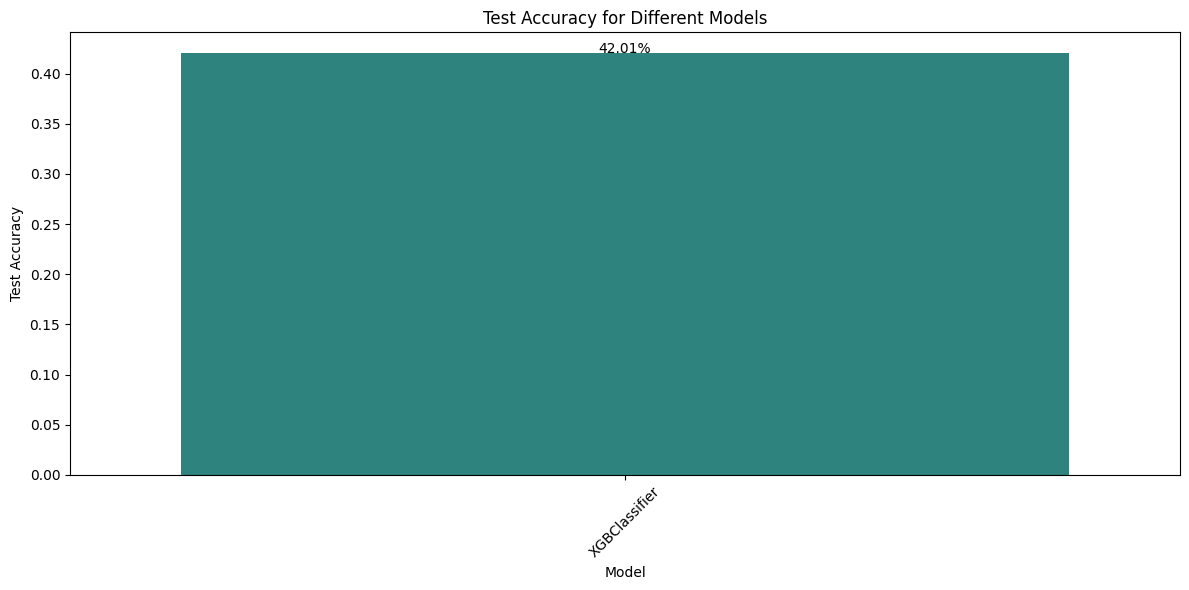

In [49]:
# Evaluate models
results_df_aug_2 = evaluate_models(trained_models_aug_2, X_test_tfidf_aug_2, y_test_aug_2)

# Plotting
plt.figure(figsize=(12, 6))

# Bar plot for test accuracy
sns.barplot(x='model', y='test_accuracy', data=results_df_aug, palette='viridis')
plt.title('Test Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)

# Adding accuracy values on top of the bars
for index, row in results_df_aug.iterrows():
    plt.text(index, row.test_accuracy, f"{row.test_accuracy:.2%}", color='black', ha="center")

plt.tight_layout()
plt.show()

# # Display the DataFrame
# print(results_df_aug)
